**Data Import**

In [ ]:
from google.colab import drive
##drive.mount("/gdrive", force_remount=True)
#base_path = "/gdrive/MyDrive/BADS/MachineLearning/data"
import os
import matplotlib.pyplot as plt
import missingno as msno

# Import necessary libraries
import pandas as pd
import numpy as np

# Load the datasets from the local CSV files
#crm_df = pd.read_csv(os.path.join(base_path, 'crm_model.csv'))
#finance_df = pd.read_csv(os.path.join(base_path, 'finance_model.csv'))
#sales_df = pd.read_csv(os.path.join(base_path, 'sales_model.csv'))

crm_df = pd.read_csv('crm_model.csv')
finance_df = pd.read_csv( 'finance_model.csv')
sales_df = pd.read_csv( 'sales_model.csv')

# Display the first few rows of the sales dataset to inspect the date columns
print("Sales Dataset - First 5 rows:")
print(sales_df.head())



Sales Dataset - First 5 rows:
  ID_SALES Program_Code  From_Grade  To_Grade Group_State  Days Travel_Type  \
0  CC1387A           CC        10.0      10.0          CA    24           A   
1   CC139A           CC         5.0       6.0          CA    18           A   
2  CC1600A           CC         7.0       7.0          OR    13           A   
3  CC1701A           CC         8.0       8.0          CA    24           A   
4  CC1773A           CC         7.0       7.0          OR    13           A   

  Departure_Date Return_Date   Early_RPL  ... SPR_Product_Type  FPP  \
0     04/07/2019  05/01/2019  05/11/2018  ...       East Coast   26   
1     04/30/2019  05/18/2019  03/05/2018  ...       East Coast   21   
2     03/17/2019  03/30/2019         NaN  ...       East Coast    7   
3     05/08/2019  06/01/2019  02/07/2018  ...       East Coast   26   
4     03/17/2019  03/30/2019         NaN  ...       East Coast    7   

   Total_Pax DepartureMonth GroupGradeTypeLow  GroupGradeTypeHigh  \

In [ ]:
import pandas as pd

class DataPreprocessor:
    def __init__(self):
        self.dummy_cols_ = None  # to store dummy columns from training

    def _merge_preprocess(self, sales_df, crm_df, finance_df):
        # Work on copies to avoid modifying originals
        sales_df = sales_df.copy()
        crm_df = crm_df.copy()
        finance_df = finance_df.copy()

        # --- Date Conversion ---
        sales_df["Departure_Date"] = pd.to_datetime(sales_df["Departure_Date"])
        sales_df["Return_Date"] = pd.to_datetime(sales_df["Return_Date"])

        # --- ID Cleaning ---
        sales_df['ID_SALES'] = (
            sales_df['ID_SALES']
            .astype(str)
            .str.replace(r'\D+', '', regex=True)
            .astype(int)
        )
        finance_df['ID_FINANCE'] = (
            finance_df['ID_FINANCE']
            .astype(str)
            .str.replace(r'\D+', '', regex=True)
            .astype(int)
        )
        crm_df['ID_CRM'] = (
            crm_df['ID_CRM']
            .astype(str)
            .str.replace(r'\D+', '', regex=True)
            .astype(int)
        )

        # --- Create Join Key ---
        crm_df['ID_JOIN'] = crm_df['ID_CRM'].astype(str).str.extract(r'(\d+)', expand=False).str.zfill(5)
        finance_df['ID_JOIN'] = finance_df['ID_FINANCE'].astype(str).str.extract(r'(\d+)', expand=False).str.zfill(5)
        sales_df['ID_JOIN'] = sales_df['ID_SALES'].astype(str).str.extract(r'(\d+)', expand=False).str.zfill(5)

        # --- Remove Duplicates ---
        crm_df = crm_df.drop_duplicates(subset='ID_JOIN', keep='last')
        finance_df = finance_df.drop_duplicates(subset='ID_JOIN', keep='last')
        sales_df = sales_df.drop_duplicates(subset='ID_JOIN', keep='last')

        # --- Merge Data ---
        merged_df = sales_df.merge(crm_df, on='ID_JOIN', how='left')\
                            .merge(finance_df, on='ID_JOIN', how='left')
        merged_df = merged_df.drop(columns=["ID_SALES", "ID_CRM", "ID_FINANCE"], errors='ignore')

        # --- Drop Unnecessary Columns ---
        cols_to_drop = [
            "Special_Pay", "Early_RPL", "FirstMeeting", "LastMeeting",
            "DifferenceTraveltoFirstMeeting", "DifferenceTraveltoLastMeeting",
            "Latest_RPL", "Departure_Date", "Return_Date", "DepartureMonth",
            "Initial_System_Date", "FPP_to_School_enrollment", "Deposit_Date"
        ]
        merged_df = merged_df.drop(columns=cols_to_drop, errors='ignore')
        cols_to_delete = ['Cancelled_Pax', 'SPR_Group_Revenue', 'Total_Discount_Pax', 'Total_Pax']
        merged_df = merged_df.drop(columns=cols_to_delete, errors='ignore')

        # --- Create Grade Average ---
        if {'To_Grade', 'From_Grade'}.issubset(merged_df.columns):
            merged_df['Grade_Average'] = (merged_df['To_Grade'] + merged_df['From_Grade']) / 2
            merged_df = merged_df.drop(columns=['To_Grade', 'From_Grade'], errors='ignore')

        return merged_df

    def _process_features(self, merged_df):
        # --- Process Categorical Features ---
        selection_categorical = [
            'Program_Code', 'Group_State', 'Travel_Type', 'SPR_Product_Type',
            'GroupGradeTypeLow', 'GroupGradeTypeHigh', 'GroupGradeType',
            'MajorProgramCode', 'Poverty_Code', 'Region'
        ]
        available_cats = [col for col in selection_categorical if col in merged_df.columns]
        for col in available_cats:
            merged_df[col] = merged_df[col].fillna("Missing")
        dummies = pd.get_dummies(merged_df[available_cats], dtype=int) if available_cats else pd.DataFrame()

        # --- Process Numerical Features ---
        numerical_cols = merged_df.select_dtypes(include=['number']).columns.tolist()
        # Exclude columns that are deliberately dropped
        exclude_cols = ['Cancelled_Pax', 'SPR_Group_Revenue', 'Total_Discount_Pax',
                        'Total_Pax', 'To_Grade', 'From_Grade']
        numerical_cols = [col for col in numerical_cols if col not in exclude_cols]
        numerical_df = merged_df[numerical_cols]
        numerical_df = numerical_df.fillna(numerical_df.median())

        # --- Combine Processed Features ---
        if not dummies.empty:
            final_df = pd.concat([dummies, numerical_df], axis=1)
        else:
            final_df = numerical_df
        return final_df

    def fit_transform(self, data_tuple):
        """
        Process training data and store the dummy columns.
        The input is a tuple: (sales_df, crm_df, finance_df)
        """
        sales_df, crm_df, finance_df = data_tuple
        merged_df = self._merge_preprocess(sales_df, crm_df, finance_df)
        final_df = self._process_features(merged_df)

        # Store dummy columns from training (if any were created)
        selection_categorical = [
            'Program_Code', 'Group_State', 'Travel_Type', 'SPR_Product_Type',
            'GroupGradeTypeLow', 'GroupGradeTypeHigh', 'GroupGradeType',
            'MajorProgramCode', 'Poverty_Code', 'Region'
        ]
        if any(col in merged_df.columns for col in selection_categorical):
            dummies = pd.get_dummies(merged_df[selection_categorical].fillna("Missing"), dtype=int)
            self.dummy_cols_ = list(dummies.columns)
        else:
            self.dummy_cols_ = []
        return final_df

    def transform(self, data_tuple):
        """
        Process test data and align dummy features to the training set.
        The input is a tuple: (sales_df, crm_df, finance_df)
        """
        sales_df, crm_df, finance_df = data_tuple
        merged_df = self._merge_preprocess(sales_df, crm_df, finance_df)

        # Process categorical dummies
        selection_categorical = [
            'Program_Code', 'Group_State', 'Travel_Type', 'SPR_Product_Type',
            'GroupGradeTypeLow', 'GroupGradeTypeHigh', 'GroupGradeType',
            'MajorProgramCode', 'Poverty_Code', 'Region'
        ]
        available_cats = [col for col in selection_categorical if col in merged_df.columns]
        for col in available_cats:
            merged_df[col] = merged_df[col].fillna("Missing")
        test_dummies = pd.get_dummies(merged_df[available_cats], dtype=int) if available_cats else pd.DataFrame()
        # Align dummy columns to those from training:
        if self.dummy_cols_:
            test_dummies = test_dummies.reindex(columns=self.dummy_cols_, fill_value=0)

        # Process numerical features (same as training)
        numerical_cols = merged_df.select_dtypes(include=['number']).columns.tolist()
        exclude_cols = ['Cancelled_Pax', 'SPR_Group_Revenue', 'Total_Discount_Pax',
                        'Total_Pax', 'To_Grade', 'From_Grade']
        numerical_cols = [col for col in numerical_cols if col not in exclude_cols]
        numerical_df = merged_df[numerical_cols]
        numerical_df = numerical_df.fillna(numerical_df.median())

        if not test_dummies.empty:
            final_df = pd.concat([test_dummies, numerical_df], axis=1)
        else:
            final_df = numerical_df
        return final_df


In [ ]:
# For training:
preprocessor = DataPreprocessor()
final_train = preprocessor.fit_transform((sales_df, crm_df, finance_df))

In [ ]:
final_train.head()

,Program_Code_CC,Program_Code_CD,Program_Code_CN,Program_Code_CVP,Program_Code_FN,Program_Code_HC,Program_Code_HD,Program_Code_HF,Program_Code_HG,Program_Code_HH,...,MDR_High_Grade,Total_School_Enrollment,SPR_New_Existing,NumberOfMeetingswithParents,Tuition,FRP_Active,FRP_Cancelled,School_Sponsor,Num_of_Non_FPP_PAX,Grade_Average
0,1,0,0,0,0,0,0,0,0,0,...,12.0,196.0,1.0,2.0,2383.0,9.0,1.0,0.0,1.0,10.0
1,1,0,0,0,0,0,0,0,0,0,...,8.0,102.0,0.0,1.0,2629.0,12.0,3.0,0.0,3.0,5.5
2,1,0,0,0,0,0,0,0,0,0,...,8.0,583.0,1.0,1.0,1710.0,12.0,2.0,0.0,2.0,7.0
3,1,0,0,0,0,0,0,0,0,0,...,8.0,158.0,0.0,1.0,2353.0,9.0,3.0,0.0,3.0,8.0
4,1,0,0,0,0,0,0,0,0,0,...,8.0,55.0,1.0,1.0,2129.0,3.0,0.0,1.0,1.0,7.0


**Data** **Preprocessing**

Our data preprocessing began by converting the Departure_Date and Return_Date columns in the Sales dataset into datetime objects, enabling us to derive time-based metrics such as trip duration. Next, we standardized our IDs across the three datasets by converting **ID_SALES** and **ID_FINANCE** to numerical values through removal of all letters, while for the CRM data we removed letters and leading zeros from **ID_CRM**. This harmonization was essential since the IDs were originally stored in mixed formats. Finally, we created a new join key, removed duplicate records, and merged the datasets via a ***left join*** on ID_SALES, resulting in a unified and clean dataset ready for model training and testing.  

In [ ]:

# Convert the date columns in the sales dataset to datetime objects.
sales_df["Departure_Date"] = pd.to_datetime(sales_df["Departure_Date"])
sales_df["Return_Date"] = pd.to_datetime(sales_df["Return_Date"])


# Convert ID_SALES to numerical IDs, dropping letters
sales_df['ID_SALES'] = sales_df['ID_SALES'].astype(str).str.replace(r'\D+', '', regex=True).astype(int)

# Convert ID_FINANCE to numerical IDs, dropping letters
finance_df['ID_FINANCE'] = finance_df['ID_FINANCE'].astype(str).str.replace(r'\D+', '', regex=True).astype(int)

# Convert ID_CRM to numerical IDs, dropping letters and initial zeros
crm_df['ID_CRM'] = crm_df['ID_CRM'].astype(str).str.replace(r'\D+', '', regex=True).astype(int)

# Display a few samples from each dataset to verify the conversion
print("Sales IDs sample:", sales_df['ID_SALES'].head())
print("CRM IDs sample:", crm_df['ID_CRM'].head())
print("Finance IDs sample:", finance_df['ID_FINANCE'].head())


Sales IDs sample: 0    1387
1     139
2    1600
3    1701
4    1773
Name: ID_SALES, dtype: int64
CRM IDs sample: 0    1000
1    1001
2    1002
3    1011
4    1013
Name: ID_CRM, dtype: int64
Finance IDs sample: 0    1389
1    3090
2    3639
3    4249
4    1021
Name: ID_FINANCE, dtype: int64


In [ ]:
# Create join key
crm_df['ID_JOIN'] = crm_df['ID_CRM'].astype(str).str.extract(r'(\d+)', expand=False).str.zfill(5)
finance_df['ID_JOIN'] = finance_df['ID_FINANCE'].astype(str).str.extract(r'(\d+)', expand=False).str.zfill(5)
sales_df['ID_JOIN'] = sales_df['ID_SALES'].astype(str).str.extract(r'(\d+)', expand=False).str.zfill(5)


# Remove duplicates
crm_df = crm_df.drop_duplicates(subset='ID_JOIN', keep='last')
finance_df = finance_df.drop_duplicates(subset='ID_JOIN', keep='last')
sales_df = sales_df.drop_duplicates(subset='ID_JOIN', keep='last')

# Merge all
merged_df = sales_df.merge(crm_df, on='ID_JOIN', how='left').merge(finance_df, on='ID_JOIN', how='left')

merged_df = merged_df.drop(columns=["ID_SALES", "ID_CRM", "ID_FINANCE"], errors='ignore')

In [ ]:
# Calculate the percentage of null values for each column in merged_df
null_percentage = merged_df.isnull().mean() * 100

# Print the percentages, sorted in descending order for better visibility
print("Percentage of Null Values for Each Column:")
print(null_percentage.sort_values(ascending=False))


Percentage of Null Values for Each Column:
Special_Pay                       80.062605
Early_RPL                         28.124248
FirstMeeting                      16.277390
LastMeeting                       16.277390
DifferenceTraveltoFirstMeeting    16.277390
DifferenceTraveltoLastMeeting     16.277390
To_Grade                           6.477245
From_Grade                         5.441849
SchoolSizeIndicator                4.237900
FPP_to_School_enrollment           3.828558
MDR_High_Grade                     3.202504
CRM_Segment                        3.009872
Income_Level                       3.009872
SPR_New_Existing                   3.009872
Region                             3.009872
School_Type                        3.009872
Poverty_Code                       3.009872
Total_School_Enrollment            3.009872
Parent_Meeting_Flag                3.009872
MDR_Low_Grade                      3.009872
SchoolGradeTypeHigh                3.009872
SchoolGradeType                  

In [ ]:
print("Sales IDs:", sales_df['ID_SALES'].head(10))
print("CRM IDs:", crm_df['ID_CRM'].head(10))


Sales IDs: 0    1387
1     139
2    1600
3    1701
4    1773
5    1830
6    1836
7     242
8    2531
9    2637
Name: ID_SALES, dtype: int64
CRM IDs: 0     1000
1     1001
2     1002
3     1011
4     1013
5    10140
6     1018
7     1026
8     1028
9    10310
Name: ID_CRM, dtype: int64


In [ ]:
print("Unique Sales IDs:", len(sales_df['ID_SALES'].unique()))
print("Unique CRM IDs:", len(crm_df['ID_CRM'].unique()))
# Check intersection
set_sales = set(sales_df['ID_SALES'].unique())
set_crm = set(crm_df['ID_CRM'].unique())
print("Number of matching IDs:", len(set_sales.intersection(set_crm)))



Unique Sales IDs: 4153
Unique CRM IDs: 4131
Number of matching IDs: 4028


In [ ]:
sample_df = merged_df[['ID_JOIN']].sample(10) # Removed ID_SALES, ID_CRM, replaced with ID_JOIN
print(sample_df)

     ID_JOIN
3916   02494
1576   00260
3761   00760
4067   01283
4061   00706
1098   01680
2671   04623
3637   00092
3095   00848
2082   00356


<Axes: >

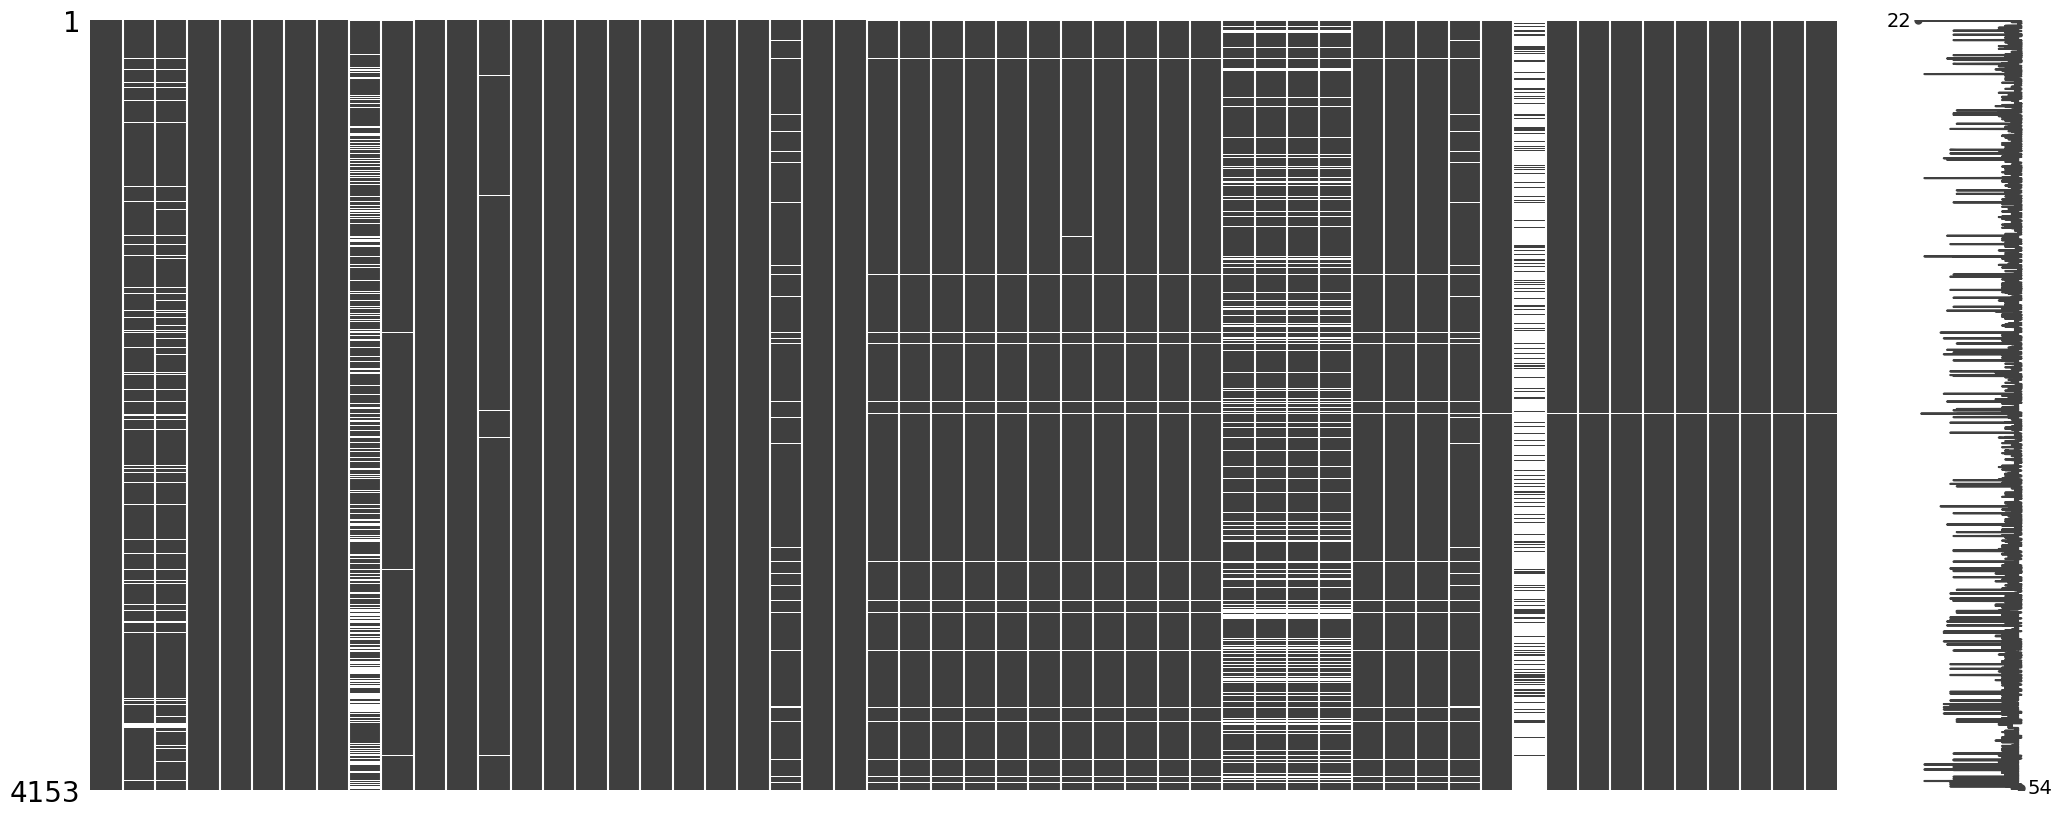

In [ ]:
# Plot with labels
msno.matrix(merged_df)

In [ ]:
merged_df.head()

,Program_Code,From_Grade,To_Grade,Group_State,Days,Travel_Type,Departure_Date,Return_Date,Early_RPL,Latest_RPL,...,Special_Pay,Tuition,FRP_Active,FRP_Cancelled,FRP_Take_up_percent_,EZ_Pay_Take_Up_Rate,School_Sponsor,SPR_Group_Revenue,FPP_to_PAX,Num_of_Non_FPP_PAX
0,CC,10.0,10.0,CA,24,A,2019-04-07,2019-05-01,05/11/2018,04/10/2018,...,NaN,2383.0,9.0,1.0,"0,34574559493049","0,103221687115555",0.0,2167.0,"0,99141462545603",1.0
1,CC,5.0,6.0,CA,18,A,2019-04-30,2019-05-18,03/05/2018,03/06/2018,...,NaN,2629.0,12.0,3.0,"0,570243822206344","0,119431395449224",0.0,2708.0,"0,888166109478944",3.0
2,CC,7.0,7.0,OR,13,A,2019-03-17,2019-03-30,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CC,8.0,8.0,CA,24,A,2019-05-08,2019-06-01,02/07/2018,08/18/2018,...,NaN,2353.0,9.0,3.0,"0,404058189011336","0,10402818131315",0.0,2148.0,"0,915160915093646",3.0
4,CC,7.0,7.0,OR,13,A,2019-03-17,2019-03-30,NaN,NaN,...,NaN,2129.0,3.0,0.0,"0,517738200915211",0,1.0,1989.0,"0,866585225868707",1.0


**Data Cleaning**

After analyzing the percentage of missing values, we noticed that Special_Pay had about **80%** missing and Early_RPL around **28%**, while FirstMeeting, LastMeeting, DifferenceTraveltoFirstMeeting, and DifferenceTraveltoLastMeeting each had about **16%** missing. Based on our threshold, we decided to remove any column with more than 16% null values. Additionally, we dropped date columns like ***Initial_System_Date*** and ***Deposit_Date***, as our analysis indicated they were not relevant for the predictive task and, in their raw Day/Month/Year format, posed challenges for most algorithms. These decisions allowed us to focus on the most pertinent predictors, enhancing our understanding of the data and ensuring that the model was built on reliable and meaningful features.  **testo in grassetto**

In [ ]:
# Create a list of columns you want to drop
cols_to_drop = [
    "Special_Pay",
    "Early_RPL",
    "FirstMeeting",
    "LastMeeting",
    "DifferenceTraveltoFirstMeeting",
    "DifferenceTraveltoLastMeeting",
    "Latest_RPL",
    "Departure_Date",
    "Return_Date",
    "DepartureMonth",
    "Initial_System_Date",
    "FPP_to_School_enrollment",
    "Deposit_Date"
]

# Drop these columns from your merged DataFrame
merged_df = merged_df.drop(columns=cols_to_drop)

# Quick check: Print remaining columns to confirm they were removed
print("Columns after dropping:", merged_df.columns)


Columns after dropping: Index(['Program_Code', 'From_Grade', 'To_Grade', 'Group_State', 'Days',
       'Travel_Type', 'Cancelled_Pax', 'Total_Discount_Pax',
       'SPR_Product_Type', 'FPP', 'Total_Pax', 'GroupGradeTypeLow',
       'GroupGradeTypeHigh', 'GroupGradeType', 'MajorProgramCode', 'Retained',
       'ID_JOIN', 'Poverty_Code', 'Region', 'CRM_Segment', 'School_Type',
       'Parent_Meeting_Flag', 'MDR_Low_Grade', 'MDR_High_Grade',
       'Total_School_Enrollment', 'Income_Level', 'SPR_New_Existing',
       'NumberOfMeetingswithParents', 'SchoolGradeTypeLow',
       'SchoolGradeTypeHigh', 'SchoolGradeType', 'SchoolSizeIndicator',
       'Tuition', 'FRP_Active', 'FRP_Cancelled', 'FRP_Take_up_percent_',
       'EZ_Pay_Take_Up_Rate', 'School_Sponsor', 'SPR_Group_Revenue',
       'FPP_to_PAX', 'Num_of_Non_FPP_PAX'],
      dtype='object')


In [ ]:
# List numeric columns
numeric_cols = merged_df.select_dtypes(include=['int64', 'float64']).columns
print("Numeric Columns:", list(numeric_cols))

# List categorical columns
categorical_cols = merged_df.select_dtypes(include=['object', 'category']).columns
print("Categorical Columns:", list(categorical_cols))


Numeric Columns: ['From_Grade', 'To_Grade', 'Days', 'Cancelled_Pax', 'Total_Discount_Pax', 'FPP', 'Total_Pax', 'Retained', 'CRM_Segment', 'Parent_Meeting_Flag', 'MDR_High_Grade', 'Total_School_Enrollment', 'SPR_New_Existing', 'NumberOfMeetingswithParents', 'Tuition', 'FRP_Active', 'FRP_Cancelled', 'School_Sponsor', 'SPR_Group_Revenue', 'Num_of_Non_FPP_PAX']
Categorical Columns: ['Program_Code', 'Group_State', 'Travel_Type', 'SPR_Product_Type', 'GroupGradeTypeLow', 'GroupGradeTypeHigh', 'GroupGradeType', 'MajorProgramCode', 'ID_JOIN', 'Poverty_Code', 'Region', 'School_Type', 'MDR_Low_Grade', 'Income_Level', 'SchoolGradeTypeLow', 'SchoolGradeTypeHigh', 'SchoolGradeType', 'SchoolSizeIndicator', 'FRP_Take_up_percent_', 'EZ_Pay_Take_Up_Rate', 'FPP_to_PAX']


In [ ]:
merged_df.dtypes

,0
Program_Code,object
From_Grade,float64
To_Grade,float64
Group_State,object
Days,int64
Travel_Type,object
Cancelled_Pax,int64
Total_Discount_Pax,int64
SPR_Product_Type,object
FPP,int64


In [ ]:
merged_df_categorical=merged_df.select_dtypes(include=['object', 'object'])
merged_df_categorical.head()

,Program_Code,Group_State,Travel_Type,SPR_Product_Type,GroupGradeTypeLow,GroupGradeTypeHigh,GroupGradeType,MajorProgramCode,ID_JOIN,Poverty_Code,...,School_Type,MDR_Low_Grade,Income_Level,SchoolGradeTypeLow,SchoolGradeTypeHigh,SchoolGradeType,SchoolSizeIndicator,FRP_Take_up_percent_,EZ_Pay_Take_Up_Rate,FPP_to_PAX
0,CC,CA,A,East Coast,K,High,K->High,C,01387,0,...,CHD,K,O,Middle,Middle,Middle->Middle,S,"0,34574559493049","0,103221687115555","0,99141462545603"
1,CC,CA,A,East Coast,PK,Middle,PK->Middle,C,00139,0,...,CHD,PK,O,Middle,Middle,Middle->Middle,S,"0,570243822206344","0,119431395449224","0,888166109478944"
2,CC,OR,A,East Coast,K,Middle,K->Middle,C,01600,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CC,CA,A,East Coast,PK,Middle,PK->Middle,C,01701,0,...,Private non-Christian,PK,Z,Middle,Middle,Middle->Middle,S,"0,404058189011336","0,10402818131315","0,915160915093646"
4,CC,OR,A,East Coast,K,Middle,K->Middle,C,01773,0,...,CHD,K,K,Middle,Middle,Middle->Middle,S,"0,517738200915211",0,"0,866585225868707"


In [ ]:
merged_df_numerical=merged_df.select_dtypes(include=[np.number])
merged_df_numerical.head()

,From_Grade,To_Grade,Days,Cancelled_Pax,Total_Discount_Pax,FPP,Total_Pax,Retained,CRM_Segment,Parent_Meeting_Flag,MDR_High_Grade,Total_School_Enrollment,SPR_New_Existing,NumberOfMeetingswithParents,Tuition,FRP_Active,FRP_Cancelled,School_Sponsor,SPR_Group_Revenue,Num_of_Non_FPP_PAX
0,10.0,10.0,24,2,1,26,29,1,10.0,1.0,12.0,196.0,1.0,2.0,2383.0,9.0,1.0,0.0,2167.0,1.0
1,5.0,6.0,18,2,3,21,22,0,9.0,1.0,8.0,102.0,0.0,1.0,2629.0,12.0,3.0,0.0,2708.0,3.0
2,7.0,7.0,13,0,1,7,7,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8.0,8.0,24,5,3,26,25,1,11.0,1.0,8.0,158.0,0.0,1.0,2353.0,9.0,3.0,0.0,2148.0,3.0
4,7.0,7.0,13,0,1,7,7,1,1.0,1.0,8.0,55.0,1.0,1.0,2129.0,3.0,0.0,1.0,1989.0,1.0


**Categorical Data**

We then performed ***bivariate analysis*** by plotting each categorical predictor against our target variable, "**Retained or Not Retained**." This allowed us to observe how each variable behaved with respect to retention and identify significant patterns. The insights gained helped us pinpoint which predictors were meaningful and which could be excluded from the final model.  


In [ ]:
merged_df_categorical.shape

(4153, 21)

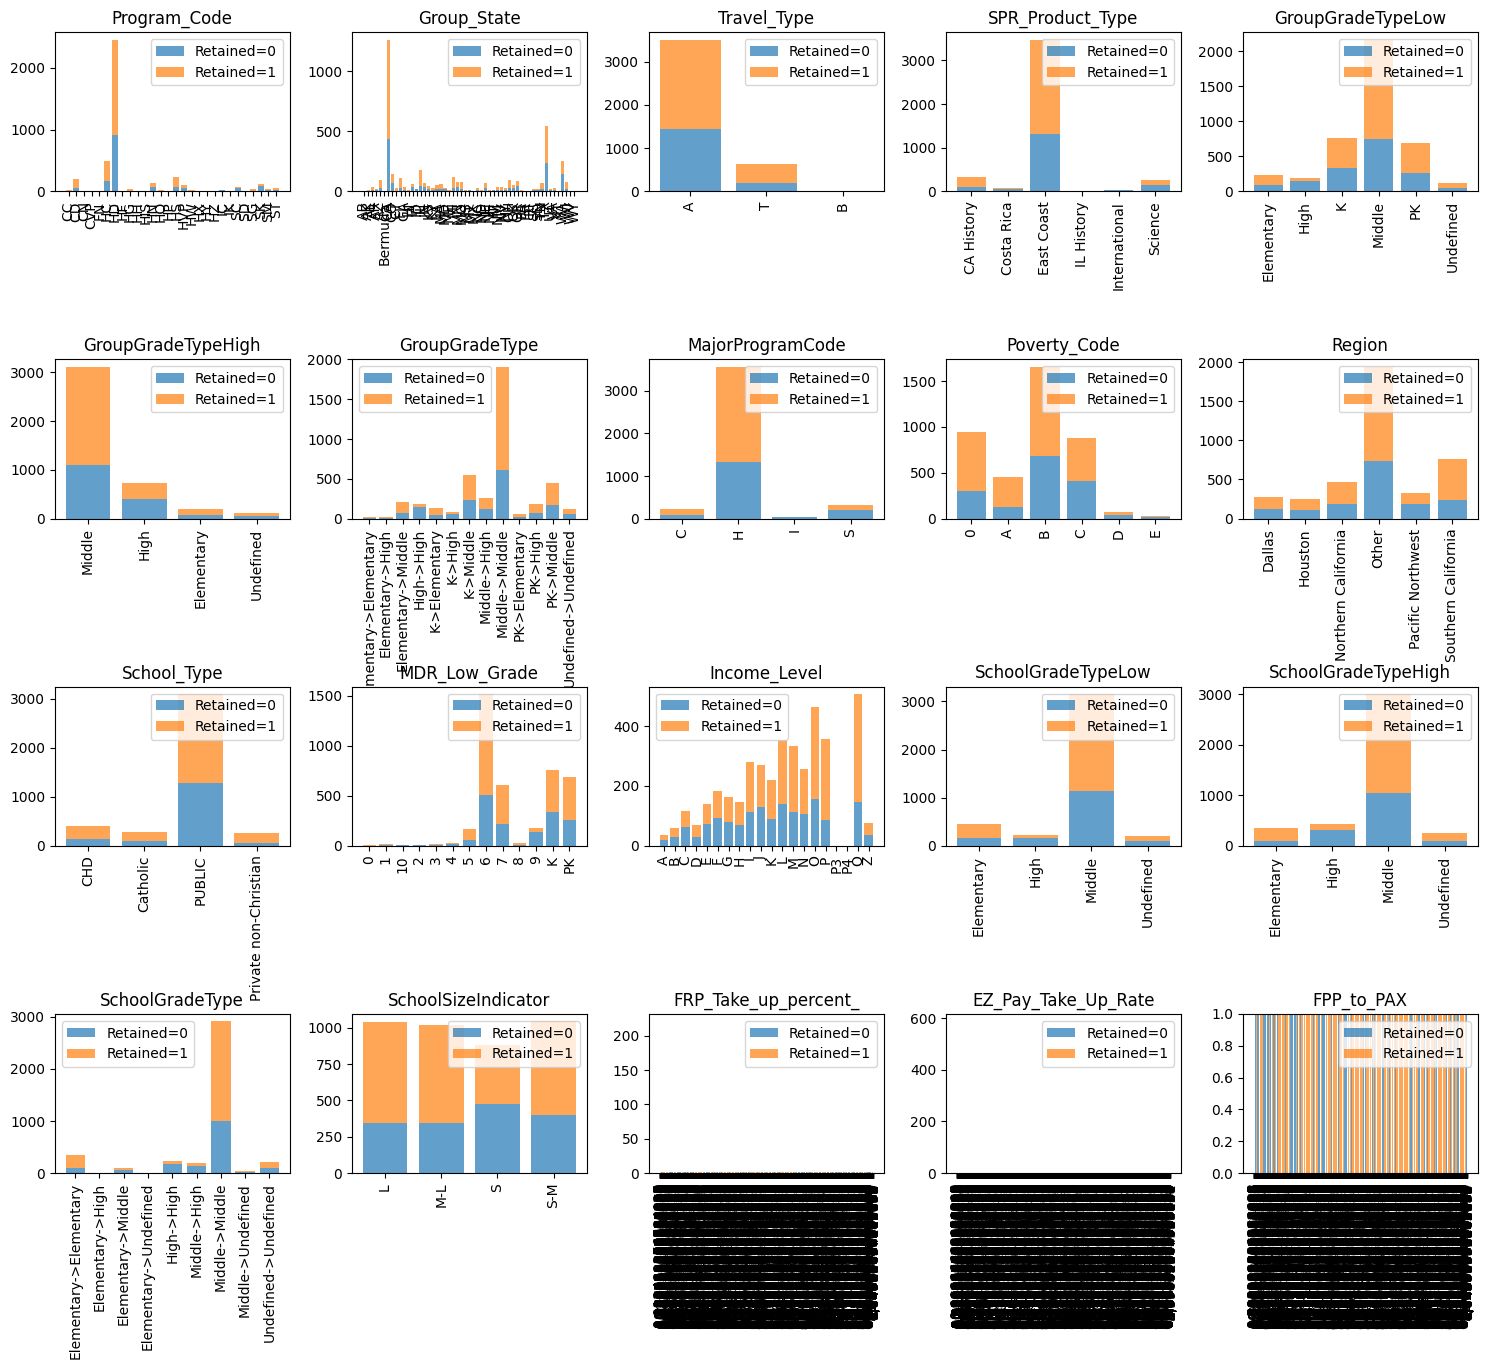

In [ ]:
merged_df_0 = merged_df_categorical[merged_df['Retained'] == 0]
merged_df_1 = merged_df_categorical[merged_df['Retained'] == 1]


# Exclude 'ID_JOIN' from the columns to be plotted
categorical_cols_to_plot = [col for col in merged_df_categorical.columns if col != 'ID_JOIN']

n_cols = 5
n_rows = math.ceil(len(categorical_cols_to_plot) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=[n_cols * 3, n_rows * 3])
axes = axes.flatten()
fig.tight_layout(h_pad=10)

for i, x in enumerate(categorical_cols_to_plot):
    plt.sca(axes[i])
    if pd.api.types.is_numeric_dtype(merged_df_categorical[x]):
        plt.hist([merged_df_0[x], merged_df_1[x]], density=True, bins=10)
    else:
        unique_values_0 = merged_df_0[x].value_counts()
        unique_values_1 = merged_df_1[x].value_counts()
        all_unique_values = unique_values_0.index.union(unique_values_1.index)
        plt.bar(all_unique_values, [unique_values_0.get(val, 0) for val in all_unique_values], label='Retained=0', alpha=0.7)
        plt.bar(all_unique_values, [unique_values_1.get(val, 0) for val in all_unique_values], label='Retained=1', alpha=0.7, bottom=[unique_values_0.get(val, 0) for val in all_unique_values])

    plt.xticks(rotation=90)
    plt.title(x)
    plt.legend()

# Hide any unused subplots
for j in range(len(categorical_cols_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.show()

In this chart, each categorical predictor is plotted side by side for retained versus non-retained customers, allowing us to see immediately which categories are tied to higher or lower retention rates. For example, under **Program_Code**, ***“TT”*** shows a distinctly taller bar for retained customers, indicating it may be a strong predictor of loyalty. In contrast, some categories in **Region**, like ***“Pacific Northwest”*** display bars for retained and non-retained that are almost the same height, suggesting that variable may not add as much predictive power. Observations like these guide us in determining which predictors warrant closer attention for modeling and which might be less influential in forecasting retention.  

In [ ]:
selection_categorical=['Program_Code', 'Group_State', 'Travel_Type', 'SPR_Product_Type','GroupGradeTypeLow', 'GroupGradeTypeHigh', 'GroupGradeType','MajorProgramCode', 'Poverty_Code', 'Region' ]

dummies = pd.get_dummies(merged_df_categorical[selection_categorical])

dummies.tail()

,Program_Code_CC,Program_Code_CD,Program_Code_CN,Program_Code_CVP,Program_Code_FN,Program_Code_HC,Program_Code_HD,Program_Code_HF,Program_Code_HG,Program_Code_HH,...,Poverty_Code_B,Poverty_Code_C,Poverty_Code_D,Poverty_Code_E,Region_Dallas,Region_Houston,Region_Northern California,Region_Other,Region_Pacific Northwest,Region_Southern California
4148,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4149,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,True,False
4150,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,True,False,False
4151,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,True,False,False
4152,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,True,False,False


We then generated ***contingency tables ***with the target variable “Retained” to further validate the patterns observed in the bivariate bar plots. For instance, in the **Program_Code vs. Retained** table, we can see exactly how many customers from each program code were retained or not retained, allowing us to confirm whether certain codes (e.g., ***“CC”*** or ***“HD”***) demonstrate a strong correlation with loyalty. These frequency counts offer a direct, numerical view of how each category is distributed by retention status, reinforcing our earlier insights about which predictors might be most influential in the model.  
Similarly, in the contingency table for **Region vs. Retained**, we can see **'Pacific Northwest '** (PN) showing a relatively closer distribution (181 vs. 151), thus confirming our bivariate analysis, which previously highlighted pronounced differences in retention for PN. Observations like these help confirm where regional factors play a significant role in predicting loyalty and where they might have more limited impact.  

In [ ]:
# List of categorical variables you want to analyze.
# Replace the list below with your actual categorical column names as needed.
categorical_vars = ['Program_Code', 'Group_State', 'Travel_Type', 'SPR_Product_Type','GroupGradeTypeLow', 'GroupGradeTypeHigh', 'GroupGradeType','MajorProgramCode', 'Poverty_Code', 'Region']
# Loop over each variable and generate its contingency table with the target 'Retained'
for var in categorical_vars:
    print(f"Contingency Table: {var} vs Retained")
    contingency_table = pd.crosstab(merged_df[var], merged_df['Retained'])
    print(contingency_table)
    print("\n")

Contingency Table: Program_Code vs Retained
Retained        0     1
Program_Code           
CC              8    18
CD             60   136
CN              2     6
CVP             5     0
FN              2     0
HC            171   320
HD            911  1540
HF              4     7
HG             10    36
HH              6     0
HIS             3     5
HN             69    59
HO              8    12
HP              0     6
HS             78   159
HVP            54    52
HW              8     7
HX              2     4
HY              4     9
HZ              2    11
IC             21     2
IK              6     0
SC             55    21
SD              6     0
SG              5    29
SK             81    44
SM             25    16
ST             25    23


Contingency Table: Group_State vs Retained
Retained       0    1
Group_State          
AB             2    0
AK             6    2
AL            14   24
AR             8    8
AZ            30   61
Bermuda        1    0
CA           43

**Numerical Data**

Based on the histogram plots shown in the image, we observed that a few key numerical variables exhibit pronounced ***skewness.*** For example, the distribution of Days is right-skewed: most trips have a relatively short duration, but there is a long tail indicating that a smaller number of trips last much longer. Similarly, the Tuition variable appears to be heavily right-skewed, with a concentration of lower values and a few extreme outliers driving the distribution toward the higher end. There may also be some skewness present in the Total Pax variable, suggesting that while most groups have a similar size, there are instances of unusually large groups. These skewed distributions indicate that applying transformations such as a logarithmic scale could help normalize the data and potentially improve model performance.  

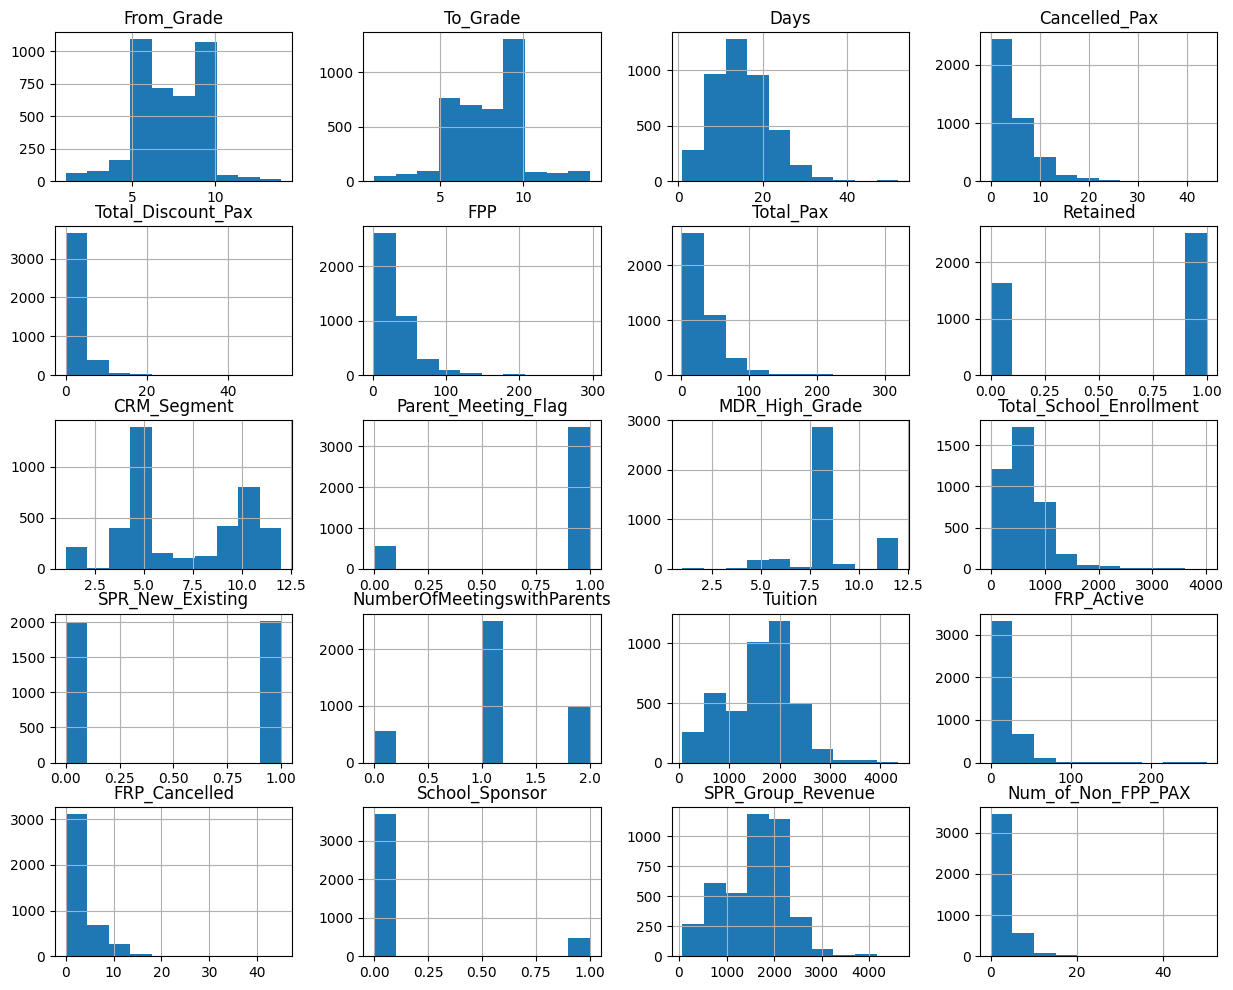

In [ ]:
 #Calculate the required number of rows and columns for the layout
num_cols = merged_df_numerical.shape[1]
num_rows = int(np.ceil(num_cols / 4))

# Create a grid of subplots that accommodates all numeric features
merged_df_hist = merged_df_numerical.hist(
    layout=(num_rows, 4),
    figsize=(15, 12)
)

In [ ]:
import math
pd.options.mode.chained_assignment = None

import math
import pandas as pd
pd.options.mode.chained_assignment = None

merged_df_numerical['logDays']=merged_df_numerical['Days'].apply(lambda x: math.log(x+1))
merged_df_numerical['logTotal_Pax']=merged_df_numerical['Total_Pax'].apply(lambda x: math.log(x+1))
merged_df_numerical['logTuition']=merged_df_numerical['Tuition'].apply(lambda x: math.log(x+1))

In [ ]:
merged_df_numerical.head(3)

,From_Grade,To_Grade,Days,Cancelled_Pax,Total_Discount_Pax,FPP,Total_Pax,Retained,CRM_Segment,Parent_Meeting_Flag,...,NumberOfMeetingswithParents,Tuition,FRP_Active,FRP_Cancelled,School_Sponsor,SPR_Group_Revenue,Num_of_Non_FPP_PAX,logDays,logTotal_Pax,logTuition
0,10.0,10.0,24,2,1,26,29,1,10.0,1.0,...,2.0,2383.0,9.0,1.0,0.0,2167.0,1.0,3.218876,3.401197,7.776535
1,5.0,6.0,18,2,3,21,22,0,9.0,1.0,...,1.0,2629.0,12.0,3.0,0.0,2708.0,3.0,2.944439,3.135494,7.874739
2,7.0,7.0,13,0,1,7,7,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.639057,2.079442,NaN


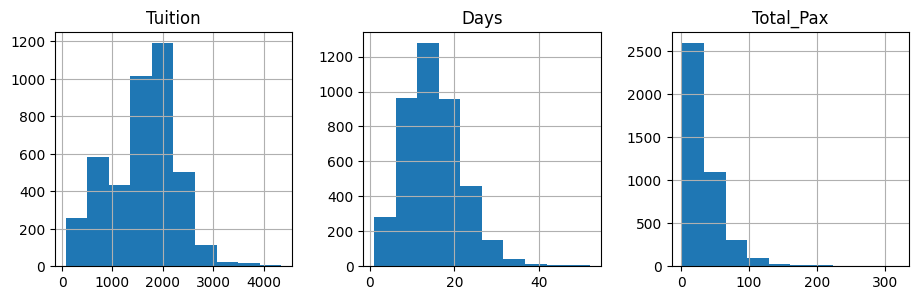

In [ ]:
merged_df_hist=merged_df_numerical[['Tuition','Days', 'Total_Pax']].hist(layout=(2,4), figsize=(15,7))

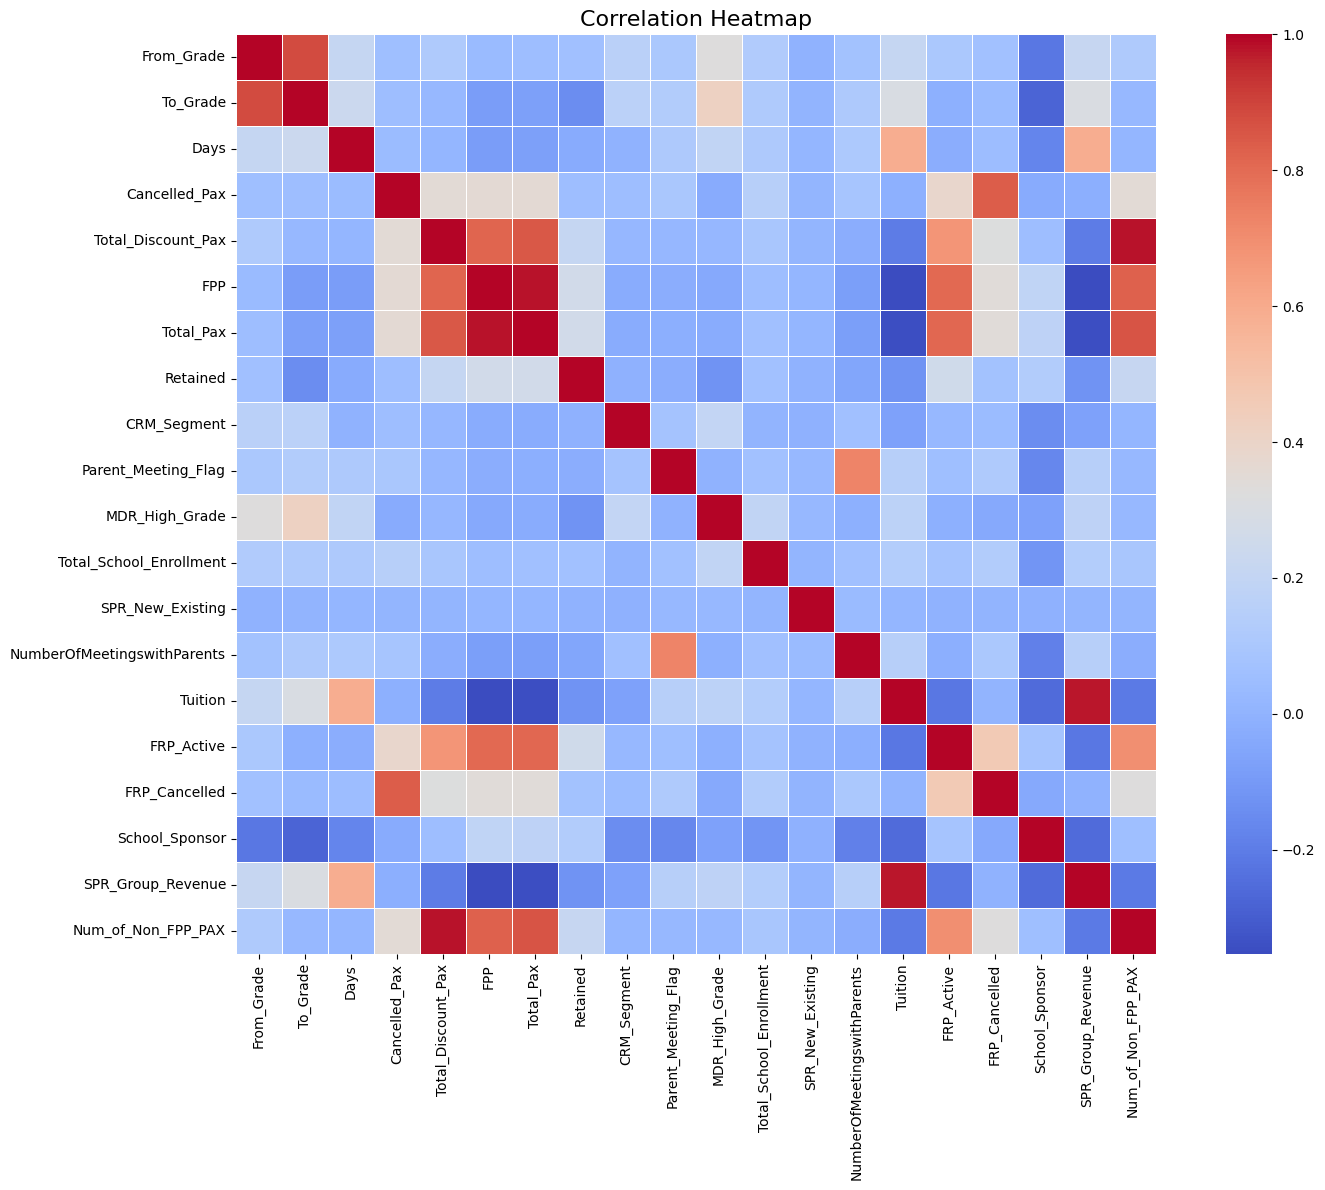

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

def gini_with_target(df, feature_col):
    """
    Calculates the Gini impurity of a feature with respect to the target variable 'Retained'.
    """

    counts = df.groupby([feature_col, 'Retained'])['Retained'].count().unstack(fill_value=0)

    total_counts = counts.sum(axis=1)

    gini_values = 1 - (counts[0] / total_counts)**2 - (counts[1] / total_counts)**2

    weighted_gini = (total_counts / total_counts.sum()) * gini_values

    return weighted_gini.sum()


# Computing and plotting initial correlation heatmap outside the function:
numeric_df = merged_df.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f",
            linewidths=0.5, cbar=True, square=True)
plt.title("Correlation Heatmap", fontsize=16)
plt.tight_layout()
plt.show()



In [ ]:
# Identifying highly correlated pairs based on bivariate Gini:
corr_matrix = numeric_df.corr().abs()
corr_threshold = 0.8
high_corr_pairs = set()

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i, j] > corr_threshold:
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]

            if (col1 in merged_df.columns and col2 in merged_df.columns and
                col1 != 'Retained' and col2 != 'Retained'):
                high_corr_pairs.add((col1, col2))

print("\nHighly Correlated Pairs (above threshold):")
if high_corr_pairs:
    for col1, col2 in high_corr_pairs:
        print(f"{col1} and {col2}: {corr_matrix.loc[col1, col2]:.2f}")



Highly Correlated Pairs (above threshold):
Num_of_Non_FPP_PAX and FPP: 0.83
Total_Pax and Total_Discount_Pax: 0.85
FRP_Active and Total_Pax: 0.81
FRP_Cancelled and Cancelled_Pax: 0.84
SPR_Group_Revenue and Tuition: 0.98
Num_of_Non_FPP_PAX and Total_Discount_Pax: 0.98
Num_of_Non_FPP_PAX and Total_Pax: 0.86
FRP_Active and FPP: 0.81
To_Grade and From_Grade: 0.88
Total_Pax and FPP: 0.98
FPP and Total_Discount_Pax: 0.82


In [ ]:
# Delete specified variables
merged_df = merged_df.drop(columns=['Cancelled_Pax', 'SPR_Group_Revenue', 'Total_Discount_Pax', 'Total_Pax'])

# Create average variable for To_Grade and From_Grade
merged_df['Grade_Average'] = (merged_df['To_Grade'] + merged_df['From_Grade']) / 2

# Drop original To_Grade and From_Grade columns
merged_df = merged_df.drop(columns=['To_Grade', 'From_Grade'])

print(merged_df.head()) # Optional: Print a few rows to check the changes

  Program_Code Group_State  Days Travel_Type SPR_Product_Type  FPP  \
0           CC          CA    24           A       East Coast   26   
1           CC          CA    18           A       East Coast   21   
2           CC          OR    13           A       East Coast    7   
3           CC          CA    24           A       East Coast   26   
4           CC          OR    13           A       East Coast    7   

  GroupGradeTypeLow GroupGradeTypeHigh GroupGradeType MajorProgramCode  ...  \
0                 K               High        K->High                C  ...   
1                PK             Middle     PK->Middle                C  ...   
2                 K             Middle      K->Middle                C  ...   
3                PK             Middle     PK->Middle                C  ...   
4                 K             Middle      K->Middle                C  ...   

   SchoolSizeIndicator Tuition FRP_Active FRP_Cancelled  FRP_Take_up_percent_  \
0                    S 

Reduced numerical data:

In [ ]:

# 1. Get a list of numerical columns, excluding those you dropped:
numerical_cols = merged_df.select_dtypes(include=['number']).columns.tolist()
cols_to_exclude = ['Cancelled_Pax', 'SPR_Group_Revenue', 'Total_Discount_Pax', 'Total_Pax', 'To_Grade', 'From_Grade']  # Add any other columns you want to exclude
numerical_cols = [col for col in numerical_cols if col not in cols_to_exclude and col != 'Retained']

# 2. Select the numerical features from merged_df:
numerical_df = merged_df[numerical_cols]

# 3. Merge (concatenate) the dummies DataFrame with the numerical DataFrame:
final_df = pd.concat([dummies, numerical_df], axis=1)

# (Optional) Display the first few rows to check:
print(final_df.head())

   Program_Code_CC  Program_Code_CD  Program_Code_CN  Program_Code_CVP  \
0             True            False            False             False   
1             True            False            False             False   
2             True            False            False             False   
3             True            False            False             False   
4             True            False            False             False   

   Program_Code_FN  Program_Code_HC  Program_Code_HD  Program_Code_HF  \
0            False            False            False            False   
1            False            False            False            False   
2            False            False            False            False   
3            False            False            False            False   
4            False            False            False            False   

   Program_Code_HG  Program_Code_HH  ...  MDR_High_Grade  \
0            False            False  ...            12.0

In [ ]:
merged_df_selection_numerical = final_df[numerical_cols] # Or use 'merged_df' if it contains the relevant numerical features

In [ ]:
selection_numerical = ['Days', 'FPP', 'CRM_Segment', 'Parent_Meeting_Flag',
                       'MDR_High_Grade', 'Total_School_Enrollment', 'SPR_New_Existing',
                       'NumberOfMeetingswithParents', 'Tuition', 'FRP_Active', 'FRP_Cancelled',
                       'School_Sponsor', 'Num_of_Non_FPP_PAX', 'Grade_Average','Retained'  # Include Grade_Average
                      ]

 The output displays **overlaid histograms ** for each numeric feature, separately showing the distributions for customers who were retained and those who were not. This visualization clearly highlights differences such as shifts in the central tendency or dispersion, helping us quickly identify features with **distinct behaviors** between the **two groups**.  

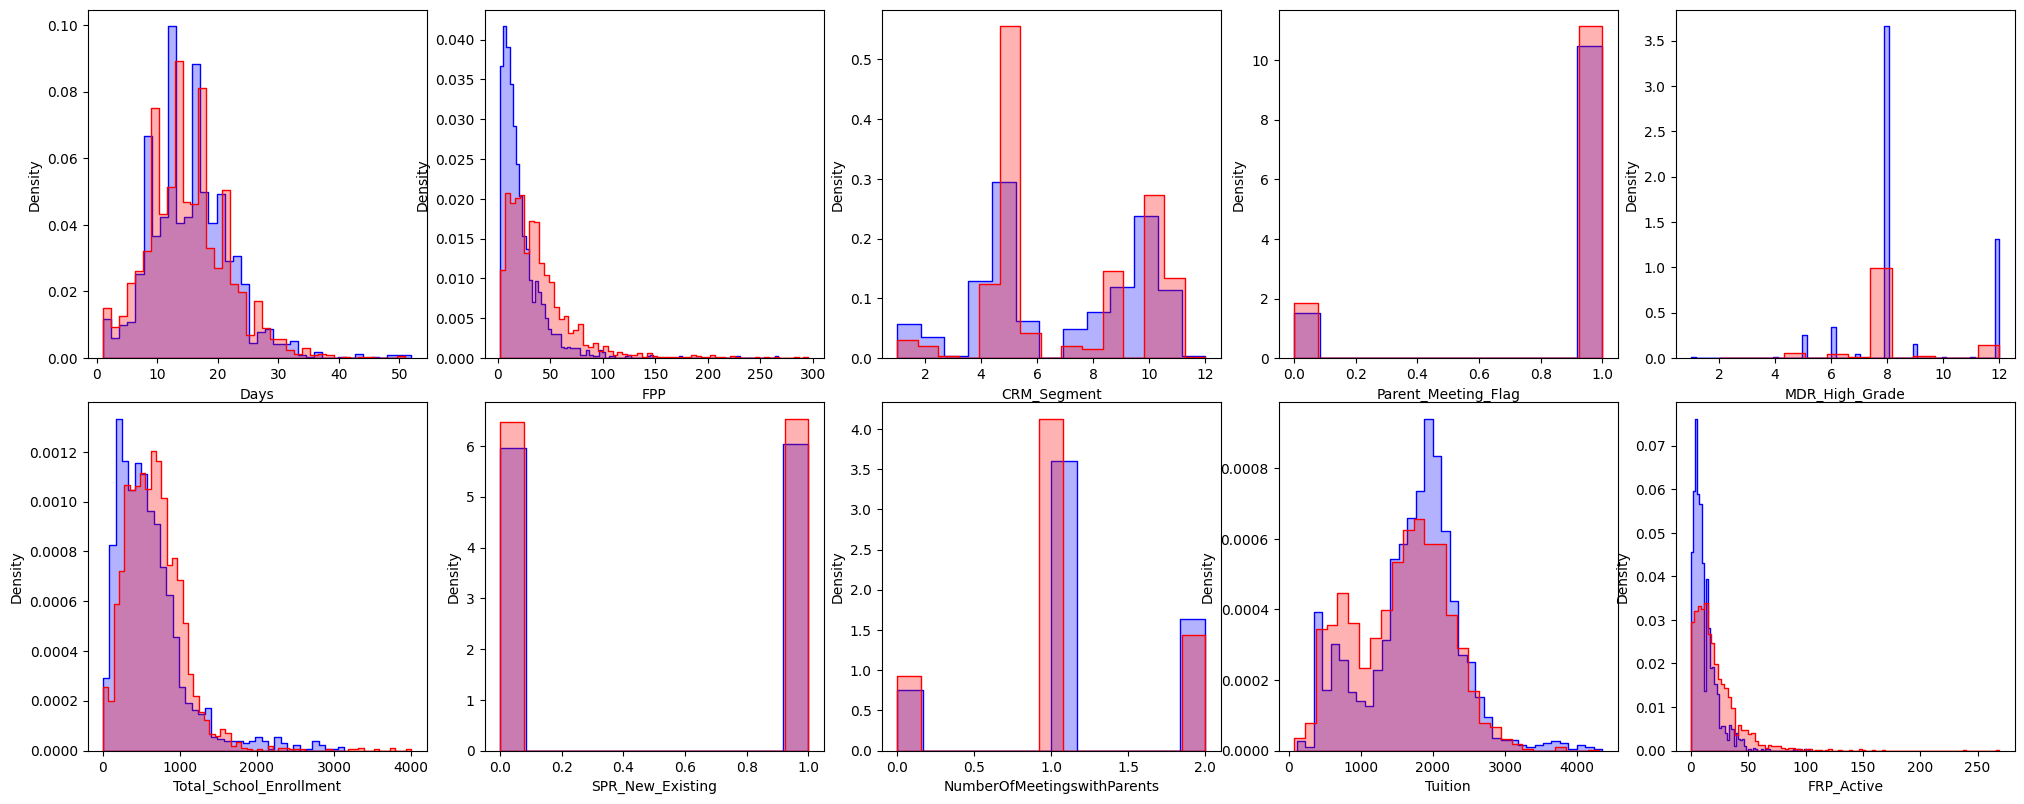

In [ ]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

# Select numerical features
merged_df_selection_numerical = final_df[numerical_cols] # Or merged_df, see explanation above

# Filter based on 'Retained' on the original DataFrame with all columns
X0 = merged_df[merged_df['Retained'] == 0][numerical_cols]
X1 = merged_df[merged_df['Retained'] == 1][numerical_cols]


fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(20,8))
fig.tight_layout()

for i, ax in zip(range(merged_df_selection_numerical.columns.size), axes.flat): # Correct variable name
    sns.histplot(X0.iloc[:,i], color="blue", ax=ax, stat='density', element="step",  alpha=0.3)
    sns.histplot(X1.iloc[:,i], color="red", ax=ax,stat='density', element="step",  alpha=0.3)
plt.show()

In [ ]:
merged_df_selection_numerical = final_df[numerical_cols] # Or use 'merged_df' if it contains the relevant numerical features

This graph is a ***pairplot*** created using Seaborn, which displays scatterplots for each pair of selected numerical variables while color-coding the data points based on the "Retained" status. Along the diagonal,  histograms (or KDE plots) show the individual distributions of each feature. We purposely used this visualization because we believed it would be valuable for our analysis—it helps us identify potential relationships and clustering patterns between variables and understand how different combinations of features might distinguish between retained and non-retained customers, thereby deepening our understanding of the underlying data structure.  

In [ ]:
#sns.pairplot(merged_df_selection_numerical, hue='Retained') # Changed 'target' to 'Retained'

**Separate Train/Test sets**

In [ ]:
y=merged_df['Retained']

In [ ]:
y.shape

(4153,)

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming 'merged_df' contains your features and 'Retained' is your target column:
# Define X (features) - exclude the 'Retained' column
X = merged_df.drop(columns=['Retained'])

# Define y (target)
y = merged_df['Retained']

#SPLIT DATA INTO TRAIN AND TEST SET
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.30, #by default is 75%-25%
                                                    stratify=y, #preserve target propotions
                                                    random_state=321) #fix random seed for replicability

print(X_train.shape, X_test.shape)

(2907, 35) (1246, 35)


**Models**

**Standarize**

In [ ]:
# Assuming merged_df is your original DataFrame
X_numerical = merged_df.select_dtypes(include=['number'])  # Select numeric columns

# Now you can use X_numerical in pd.concat
X = pd.concat([dummies, X_numerical], axis=1)
X.tail()

,Program_Code_CC,Program_Code_CD,Program_Code_CN,Program_Code_CVP,Program_Code_FN,Program_Code_HC,Program_Code_HD,Program_Code_HF,Program_Code_HG,Program_Code_HH,...,MDR_High_Grade,Total_School_Enrollment,SPR_New_Existing,NumberOfMeetingswithParents,Tuition,FRP_Active,FRP_Cancelled,School_Sponsor,Num_of_Non_FPP_PAX,Grade_Average
4148,False,False,False,False,False,False,False,False,False,False,...,9.0,644.0,0.0,1.0,2234.0,7.0,2.0,0.0,1.0,8.0
4149,False,False,False,False,False,False,False,False,False,False,...,6.0,908.0,0.0,1.0,2015.0,9.0,2.0,0.0,1.0,7.0
4150,False,False,False,False,False,False,False,False,False,False,...,8.0,553.0,0.0,1.0,1797.0,4.0,2.0,0.0,2.0,10.0
4151,False,False,False,False,False,False,False,False,False,False,...,8.0,1257.0,0.0,1.0,1936.0,6.0,0.0,0.0,2.0,7.5
4152,False,False,False,False,False,False,False,False,False,False,...,12.0,363.0,0.0,2.0,1653.0,3.0,1.0,0.0,1.0,11.5


In [ ]:
#hyperp_search(classifier,parameters)

**Tree**

In [ ]:
!pip install graphviz

**Logistic Regression**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer # Import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score

# 1. Data Loading and Preparation (assuming you have merged_df)
# --------------------------------------------------------------
# Replace 'merged_df' with your actual DataFrame name
data = merged_df

# Separate features (X) and target (y)
X = data.drop(columns=['Retained'])  # Features
y = data['Retained']                # Target

# 2. Split into Training and Testing Sets
# ---------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 3. Preprocessing with OneHotEncoder for Categorical Features
# -------------------------------------------------------------
# Identify categorical and numerical features
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_features = X_train.select_dtypes(exclude=['object']).columns.tolist()

# Create a preprocessing pipeline
# Include SimpleImputer to handle missing values in numerical features
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # or 'median', 'most_frequent'
    # Add other numerical transformations if needed
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

# 4. Build the Logistic Regression Pipeline
# -----------------------------------------
# Create a pipeline with the preprocessor and the classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))  # Adjust max_iter if needed
])

# 5. Train the Model
# ------------------
pipeline.fit(X_train, y_train)

# 6. Make Predictions
# -------------------
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

# 7. Evaluate the Model
# ---------------------
print("Training Accuracy:", accuracy_score(y_train, y_pred_train))
print("Testing Accuracy:", accuracy_score(y_test, y_pred_test))

print("\nClassification Report (Test Set):\n", classification_report(y_test, y_pred_test))

print("ROC AUC Score:", roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1]))

print("F1 Score (Train):", f1_score(y_train, y_pred_train))
print("F1 Score (Test):", f1_score(y_test, y_pred_test))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy: 0.7420020639834881
Testing Accuracy: 0.6966292134831461

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.62      0.50      0.55       466
           1       0.73      0.82      0.77       780

    accuracy                           0.70      1246
   macro avg       0.67      0.66      0.66      1246
weighted avg       0.69      0.70      0.69      1246

ROC AUC Score: 0.7392703862660945
F1 Score (Train): 0.7967479674796748
F1 Score (Test): 0.7711864406779662


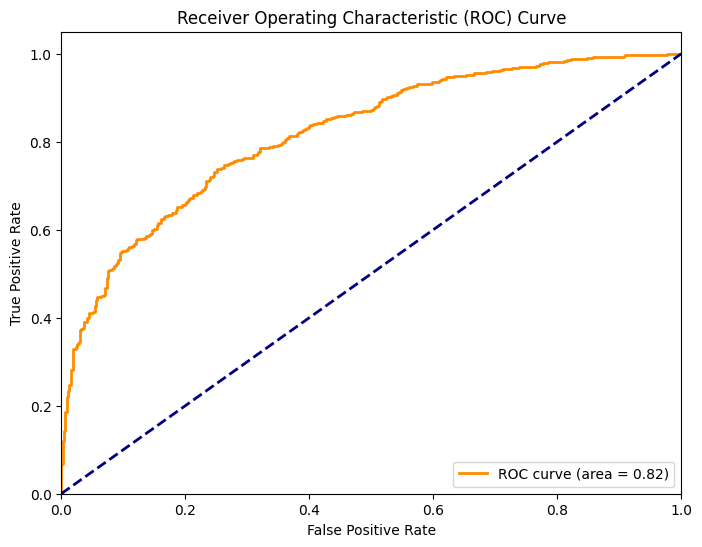

In [ ]:
# Get predicted probabilities for the positive class
y_probs = best_model.predict_proba(X_test_preprocessed)[:, 1]

# 7. Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# 8. Calculate AUC
roc_auc = auc(fpr, tpr)

# 9. Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

XGBoost

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_auc_score
from tqdm import tqdm

# 1. Load and Preprocess Data (assuming you have merged_df)
data = final_train  # Replace with your DataFrame name
X = data.drop(columns=['Retained'])
y = data['Retained']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Identify feature types
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_features = X_train.select_dtypes(exclude=['object']).columns.tolist()

# Preprocessing pipeline: impute numerical data and one-hot encode categorical features
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# 2. Define a parameter grid for XGBoost
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.01]
}
grid = list(ParameterGrid(param_grid))

# 3. Manual grid search using tqdm for progress tracking
best_score = 0
best_params = None
best_model = None

for params in tqdm(grid, desc="Grid Search", total=len(grid)):
    model = xgb.XGBClassifier(random_state=42, **params)
    model.fit(X_train_preprocessed, y_train)
    y_pred = model.predict(X_test_preprocessed)
    score = f1_score(y_test, y_pred)
    if score > best_score:
        best_score = score
        best_params = params
        best_model = model

print("Best Parameters:", best_params)
print("Best F1 Score:", best_score)

# 4. Evaluate the best model
y_pred_best = best_model.predict(X_test_preprocessed)
print("\nAccuracy:", accuracy_score(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))
print("ROC AUC Score:", roc_auc_score(y_test, best_model.predict_proba(X_test_preprocessed)[:, 1]))


Grid Search: 100%|██████████| 8/8 [00:01<00:00,  4.48it/s]

Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best F1 Score: 0.8065099457504521

Accuracy: 0.7423756019261637

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.55      0.61       466
           1       0.76      0.86      0.81       780

    accuracy                           0.74      1246
   macro avg       0.73      0.70      0.71      1246
weighted avg       0.74      0.74      0.73      1246

ROC AUC Score: 0.8191317266424563


In [ ]:
# Add this import statement at the beginning of your cell:
from sklearn.metrics import roc_curve, auc

# --- Rest of your code remains the same ---
# Calculate and print F1-scores


# --- Plot ROC AUC Curve ---
# Get predicted probabilities for the positive class
y_pred = best_model.predict(X_test_preprocessed)
f1_test = f1_score(y_test, y_pred)
print(f"F1 Score (Test): {f1_test:.4f}")
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

**Unseen Data Import**

In [ ]:
import pandas as pd

#crm_test_df = pd.read_csv(os.path.join(base_path, 'crm_test.csv'))
#finance_test_df = pd.read_csv(os.path.join(base_path, 'finance_test.csv'))
#sales_test_df = pd.read_csv(os.path.join(base_path, 'sales_test.csv'))

crm_test_df = pd.read_csv('crm_test.csv')
finance_test_df = pd.read_csv('finance_test.csv')
sales_test_df = pd.read_csv('sales_test.csv')

In [ ]:
# Make sure we have our preprocessor defined
if 'preprocessor' not in globals():
    # If not in globals, recreate it
    preprocessor = DataPreprocessor()
    preprocessor.fit_transform((sales_df, crm_df, finance_df))

# Now use it to transform the test data
final_test = preprocessor.transform((sales_test_df, crm_test_df, finance_test_df))
predictions = best_model.predict(final_test)
print(predictions)

In [107]:
def process_test_data(sales_df, crm_df, finance_df, model_features):
    """
    Process test data to match the format expected by the model.

    Parameters:
    -----------
    sales_df : pandas DataFrame
        The sales test data
    crm_df : pandas DataFrame
        The CRM test data
    finance_df : pandas DataFrame
        The finance test data
    model_features : list
        List of feature names the model was trained on and expects

    Returns:
    --------
    pandas DataFrame
        Preprocessed test data ready for prediction
    """
    import pandas as pd
    import numpy as np

    # 1. Date conversion
    if 'Departure_Date' in sales_df.columns:
        sales_df["Departure_Date"] = pd.to_datetime(sales_df["Departure_Date"])
    if 'Return_Date' in sales_df.columns:
        sales_df["Return_Date"] = pd.to_datetime(sales_df["Return_Date"])

    # 2. ID cleaning and join key creation
    sales_df['ID_SALES'] = (
        sales_df['ID_SALES']
        .astype(str)
        .str.replace(r'\D+', '', regex=True)
        .astype(int)
    )
    finance_df['ID_FINANCE'] = (
        finance_df['ID_FINANCE']
        .astype(str)
        .str.replace(r'\D+', '', regex=True)
        .astype(int)
    )
    crm_df['ID_CRM'] = (
        crm_df['ID_CRM']
        .astype(str)
        .str.replace(r'\D+', '', regex=True)
        .astype(int)
    )

    # Create join keys
    sales_df['ID_JOIN'] = sales_df['ID_SALES'].astype(str).str.extract(r'(\d+)', expand=False).str.zfill(5)
    finance_df['ID_JOIN'] = finance_df['ID_FINANCE'].astype(str).str.extract(r'(\d+)', expand=False).str.zfill(5)
    crm_df['ID_JOIN'] = crm_df['ID_CRM'].astype(str).str.extract(r'(\d+)', expand=False).str.zfill(5)

    # 3. Remove duplicates
    sales_df = sales_df.drop_duplicates(subset='ID_JOIN', keep='last')
    finance_df = finance_df.drop_duplicates(subset='ID_JOIN', keep='last')
    crm_df = crm_df.drop_duplicates(subset='ID_JOIN', keep='last')

    # 4. Merge data
    merged_df = sales_df.merge(crm_df, on='ID_JOIN', how='left').merge(finance_df, on='ID_JOIN', how='left')

    # 5. Drop unnecessary columns
    merged_df = merged_df.drop(columns=["ID_SALES", "ID_CRM", "ID_FINANCE"], errors='ignore')

    cols_to_drop = [
        "Special_Pay", "Early_RPL", "FirstMeeting", "LastMeeting",
        "DifferenceTraveltoFirstMeeting", "DifferenceTraveltoLastMeeting",
        "Latest_RPL", "Departure_Date", "Return_Date", "DepartureMonth",
        "Initial_System_Date", "FPP_to_School_enrollment", "Deposit_Date"
    ]
    merged_df = merged_df.drop(columns=cols_to_drop, errors='ignore')
    merged_df = merged_df.drop(columns=['Cancelled_Pax', 'SPR_Group_Revenue', 'Total_Discount_Pax', 'Total_Pax'], errors='ignore')

    # 6. Create Grade Average if needed
    if {'To_Grade', 'From_Grade'}.issubset(merged_df.columns):
        merged_df['Grade_Average'] = (merged_df['To_Grade'] + merged_df['From_Grade']) / 2
        merged_df = merged_df.drop(columns=['To_Grade', 'From_Grade'], errors='ignore')

    # 7. Process categorical features
    selection_categorical = [
        'Program_Code', 'Group_State', 'Travel_Type', 'SPR_Product_Type',
        'GroupGradeTypeLow', 'GroupGradeTypeHigh', 'GroupGradeType',
        'MajorProgramCode', 'Poverty_Code', 'Region'
    ]
    available_cats = [col for col in selection_categorical if col in merged_df.columns]
    for col in available_cats:
        merged_df[col] = merged_df[col].fillna("Missing")
    test_dummies = pd.get_dummies(merged_df[available_cats], dtype=int) if available_cats else pd.DataFrame()

    # 8. Process numerical features
    numerical_cols = merged_df.select_dtypes(include=['number']).columns.tolist()
    exclude_cols = ['Cancelled_Pax', 'SPR_Group_Revenue', 'Total_Discount_Pax',
                    'Total_Pax', 'To_Grade', 'From_Grade', 'Retained']
    numerical_cols = [col for col in numerical_cols if col not in exclude_cols]
    numerical_df = merged_df[numerical_cols]
    numerical_df = numerical_df.fillna(numerical_df.median())

    # 9. Combine processed features
    if not test_dummies.empty:
        final_test = pd.concat([test_dummies, numerical_df], axis=1)
    else:
        final_test = numerical_df

    # 10. CRITICAL: Make sure we only include the exact features the model expects
    # Add missing columns with zeros
    for col in model_features:
        if col not in final_test.columns:
            final_test[col] = 0

    # Keep only the columns the model expects
    final_test = final_test[model_features]

    # Return the ID_JOIN column along with the processed data for later reference
    return final_test, merged_df['ID_JOIN']

# IMPORTANT: We need to get the EXACT features the model was trained on
# Try to get them directly from the model if possible
try:
    # For XGBoost models
    model_features = best_model.feature_names_in_
    print(f"Retrieved {len(model_features)} feature names directly from the model")
except:
    try:
        # For XGBoost models (alternative attribute)
        model_features = best_model.get_booster().feature_names
        print(f"Retrieved {len(model_features)} feature names from the booster")
    except:
        # Fallback: Get features from training data but remove 'Retained' if present
        model_features = [col for col in final_train.columns if col != 'Retained']
        print(f"Using {len(model_features)} features from training data")

# Process the test data with the correct features
processed_test_data, id_join_values = process_test_data(
    sales_test_df,
    crm_test_df,
    finance_test_df,
    model_features
)

# Double-check the shape
print("Shape of processed test data:", processed_test_data.shape)
print("Number of features expected by model:", len(model_features))

# Make predictions
predictions = best_model.predict(processed_test_data)

# Create a DataFrame with predictions
results_df = pd.DataFrame({
    'ID_JOIN': id_join_values,
    'Predicted_Retention': predictions
})

# Save the results
results_df.to_csv('retention_predictions.csv', index=False)
print("Predictions saved to 'retention_predictions.csv'")
print(results_df.head())

Using 145 features from training data
Shape of processed test data: (630, 145)
Number of features expected by model: 145
Predictions saved to 'retention_predictions.csv'
  ID_JOIN  Predicted_Retention
0   01040                    1
1   01525                    1
2   02011                    0
3   01132                    0
4   01178                    1
